## Computer Vision PA #2: Structure from Motion (SfM)
20195003 고강빈

In [1]:
import numpy as np
import cv2 as cv

import os
import glob

import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath("./SfM/Step2")  # 'calibrated_fivepoint.m'가 위치한 경로

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
MAXITER = 100
threshold = 5e-4

# intrinsic parameter
K = np.array([[3451.5, 0.0, 2312.0], [0.0, 3451.5, 1734], [0.0,0.0,1.0]])
K_inv = np.linalg.inv(K)

In [ ]:
################################################################################################################################
# Step 1: Feature Extraction & Matching
################################################################################################################################
img1 = cv.imread('./SfM/Data/sfm03.jpg')
img2 = cv.imread('./SfM/Data/sfm04.jpg')

# create SIFT instance
sift = cv.SIFT_create()
# sift = cv.xfeatures2d.SIFT_create()

# detect and compute keypoints
img1_kp, img1_des = sift.detectAndCompute(img1, None)
img2_kp, img2_des = sift.detectAndCompute(img2, None)

img1_drawKps = cv.drawKeypoints(img1, img1_kp, None)
img2_drawKps = cv.drawKeypoints(img2, img2_kp, None)

# KNN matching with k=2
bf = cv.BFMatcher()
matches = bf.knnMatch(img1_des, img2_des, k=2)

# Ratio test
good = [m1 for m1, m2 in matches if m1.distance < 0.8 * m2.distance]
sorted_good = sorted(good, key=lambda x: x.distance)

print(f'# of matches: {len(sorted_good)}')

# save result as image
cv.imwrite('./results/sift_keypoints.jpg',img1_drawKps)
print('save keypoints: done')

res = cv.drawMatches(img1, img1_kp, img2, img2_kp, sorted_good, img2, flags=2) 
cv.imwrite('./results/sift_bfMatcher.jpg',res)
print('save matches: done')

# of matches: 2592
save keypoints: done
save matches: done


In [ ]:
################################################################################################################################
# Step 2: Essential Matrix Estimation
################################################################################################################################
query_idx = [good.queryIdx for good in sorted_good]
train_idx = [good.trainIdx for good in sorted_good]

kp1 = np.float32([img1_kp[idx].pt for idx in query_idx])
kp2 = np.float32([img2_kp[idx].pt for idx in train_idx])

ones = np.ones((1, len(kp1)))

q1 = np.append(kp1.T, ones, axis=0)
q2 = np.append(kp2.T, ones, axis=0)

norm_q1 = K_inv @ q1
norm_q2 = K_inv @ q2

best_in = 0
best_E = None

# 5-points algorithm / RANSAC
# for _ in tqdm(range(MAXITER)):

#     idx = np.random.randint(0, len(kp1), size=5)
#     rand_norm_q1 = norm_q1[:, idx]
#     rand_norm_q2 = norm_q2[:, idx]
#     rand_norm_q1_doub = matlab.double(rand_norm_q1.tolist())
#     rand_norm_q2_doub = matlab.double(rand_norm_q2.tolist())
    
#     E = eng.calibrated_fivepoint(rand_norm_q1_doub, rand_norm_q2_doub)
#     E = np.array(E)
    
#     for i in range(E.shape[1]):
#         cur_E = E[:,i].reshape(3,3)
        
#         estim = np.diag(norm_q2.T @ cur_E @ norm_q1)
#         cur_in = sum(np.where(((estim < threshold) & (estim >= 0)), True, False))
#         if best_in < cur_in:
#             best_in = cur_in
#             best_E = cur_E
#             inlier_idx = np.where(((estim < threshold) & (estim >= 0)))

for _ in tqdm(range(MAXITER)):

    idx = np.random.randint(0, len(kp1), size=5)
    rand_q1 = q1[:, idx]
    rand_q2 = q2[:, idx]
    rand_q1_doub = matlab.double(rand_q1.tolist())
    rand_q2_doub = matlab.double(rand_q2.tolist())
    
    E = eng.calibrated_fivepoint(rand_q1_doub, rand_q2_doub)
    E = np.array(E)
    
    for i in range(E.shape[1]):
        cur_E = E[:,i].reshape(3,3)
        
        estim = np.diag(norm_q2.T @ cur_E @ norm_q1)
        cur_in = sum(np.where(((estim < threshold) & (estim >= 0)), True, False))
        if best_in < cur_in:
            best_in = cur_in
            best_E = cur_E
            inlier_idx = np.where(((estim < threshold) & (estim >= 0)))
      
print(f'# of inliers: {best_in}')
inlier_idx = np.array(inlier_idx).reshape(-1)

# save
df = pd.DataFrame(best_E)
df.to_csv('./results/EssentialMatrix.csv')
print('save Essential Matrix: done')

100%|██████████| 100/100 [00:05<00:00, 17.41it/s]

# of inliers: 1296
save Essential Matrix: done


candidate for camera matrix
 [[[ 0.67463415  0.10672072 -0.73039677 -0.85140485]
  [ 0.07014622 -0.99428431 -0.08048736 -0.11075403]
  [-0.73481172  0.00306495 -0.67826421  0.51268249]]

 [[ 0.67463415  0.10672072 -0.73039677  0.85140485]
  [ 0.07014622 -0.99428431 -0.08048736  0.11075403]
  [-0.73481172  0.00306495 -0.67826421 -0.51268249]]

 [[ 0.95815748 -0.14218991  0.24842761 -0.85140485]
  [ 0.14225362  0.98967034  0.01779095 -0.11075403]
  [-0.24839113  0.0182932   0.96848707  0.51268249]]

 [[ 0.95815748 -0.14218991  0.24842761  0.85140485]
  [ 0.14225362  0.98967034  0.01779095  0.11075403]
  [-0.24839113  0.0182932   0.96848707 -0.51268249]]]
Matrix 0 is not good
Matrix 1 is not good
Matrix 2 is not good
Matrix 3 is not good


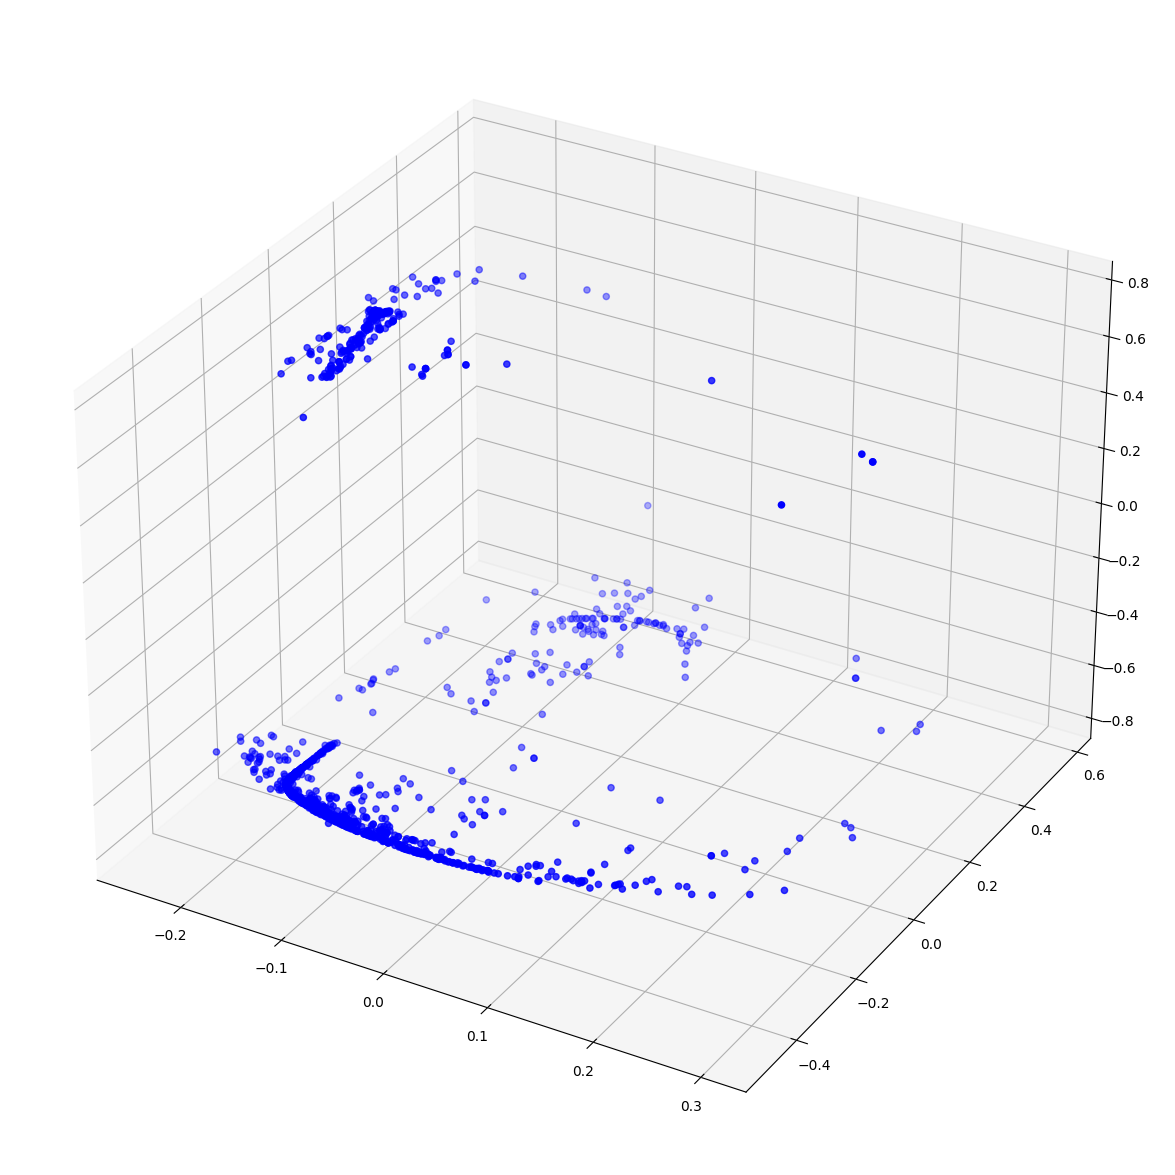

In [30]:
################################################################################################################################
# Step 3: Essential Matrix Decomposition & Step 4: Triangulation
################################################################################################################################
U, S, VT = np.linalg.svd(best_E, full_matrices=True)

W = np.array([[0.0, -1.0, 0.0],
              [1.0, 0.0, 0.0],
              [0.0, 0.0, 1.0]
              ])

P = np.array([
    np.column_stack((U @ W @ VT, U[:,2])),
    np.column_stack((U @ W @ VT, -U[:,2])),
    np.column_stack((U @ W.T @ VT, U[:,2])),
    np.column_stack((U @ W.T @ VT, -U[:,2]))])


print('candidate for camera matrix\n', P)

E_init = np.append(np.eye(3), np.zeros((3,1)), axis=1)
# for i in range(4):
#     tmp = P[i]
#     for j in range(len(inlier_idx)):
#         A = np.array([
#             norm_q1[0,j+1]*E_init[2] - E_init[0],
#             norm_q1[1,j+1]*E_init[2] - E_init[1],
#             norm_q2[0,j+1]*tmp[2] - tmp[0],
#             norm_q2[1,j+1]*tmp[2] - tmp[1]])
#         U_A, S_A, VT_A = np.linalg.svd(A, full_matrices=True)
#         X = VT_A[3]#/VT_A[3,3]
#         if X[2] > 0 and (tmp@X.T)[2]>0:
#             print(f'Matrix {i} have all positive depths!')
#             E = P[i]
#             break
#         else:
#             print(f'Matrix {i} is not good')
#             break

for i in range(4):
    tmp = P[i]
    for j in range(norm_q1.shape[1]):
        a = norm_q1[:,j].flatten()
        b = norm_q2[:,j].flatten()
        c = np.concatenate((a, b))
        d = tmp@c
        if np.any(d<0):
            print(f'Matrix {i} is not good')
            break
        else:
            print(f'Matrix {i} have all positive depths!')
            E = P[i]
            break

inlier_X = []

for i in range(len(inlier_idx)):
    A = np.array([
        norm_q1[0,i+1]*E_init[2] - E_init[0],
        norm_q1[1,i+1]*E_init[2] - E_init[1],
        norm_q2[0,i+1]*E[2] - E[0],
        norm_q2[1,i+1]*E[2] - E[1]])
    U_A, S_A, VT_A = np.linalg.svd(A, full_matrices=True)
    X = VT_A[:,-1]
    inlier_X.append(X)
    
p3ds = np.array(inlier_X).T

# visualize
X = np.array([])
Y = np.array([])
Z = np.array([])
X = np.concatenate((X, p3ds[0]))
Y = np.concatenate((Y, p3ds[1]))
Z = np.concatenate((Z, p3ds[2]))

fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.scatter3D(X, Y, Z, c='b', marker='o') 
# plt.show()
plt.savefig('./results/3D_result.jpg')

In [ ]:
################################################################################################################################
# Step 5: Growing Steps
################################################################################################################################



In [ ]:
################################################################################################################################
# Step 7: Camera Calibration
################################################################################################################################
corner_num = (6,8)
objpoints = []
imgpoints = []

# termination criteria
criteria = (2 + 1, 30, 0.001)

objpt = np.zeros((corner_num[1]*corner_num[0],3), np.float32)
objpt[:,:2] = np.mgrid[0:corner_num[0],0:corner_num[1]].T.reshape(-1,2)

images = glob.glob('./SfM/Step7/*.jpg')
for fname in tqdm(images):
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    ret, corners = cv.findChessboardCorners(gray, corner_num, None)

    if ret == True:
        objpoints.append(objpt)
        corners_tuned = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners_tuned)

In [ ]:
print(len(objpoints))
print(len(imgpoints))

In [ ]:
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(cameraMatrix)

In [ ]:
MAXITER = 100
threshold = 5e-4

# intrinsic parameter
K = np.array(cameraMatrix)
K_inv = np.linalg.inv(K)

################################################################################################################################
# Step 1: Feature Extraction & Matching
################################################################################################################################
img1 = cv.imread('./SfM/Data/own/sfm_own_01.jpg')
img2 = cv.imread('./SfM/Data/own/sfm_own_02.jpg')

# create SIFT instance
sift = cv.SIFT_create()
# sift = cv.xfeatures2d.SIFT_create()

# detect and compute keypoints
img1_kp, img1_des = sift.detectAndCompute(img1, None)
img2_kp, img2_des = sift.detectAndCompute(img2, None)

img1_drawKps = cv.drawKeypoints(img1, img1_kp, None)
img2_drawKps = cv.drawKeypoints(img2, img2_kp, None)

# save result as image
cv.imwrite('./results/own/sift_keypoints.jpg',img1_drawKps)
print('save keypoints: done')

# Brute force matching with k=2
bf = cv.BFMatcher()
matches = bf.knnMatch(img1_des, img2_des, k=2)

# Ratio test
good = [m1 for m1, m2 in matches if m1.distance < 0.8 * m2.distance]
sorted_good = sorted(good, key=lambda x: x.distance)

# save matching result as image
res = cv.drawMatches(img1, img1_kp, img2, img2_kp, sorted_good, img2, flags=2) 
cv.imwrite('./results/own/sift_bfMatcher.jpg',res)
print('save matches: done')

img1_drawKps = cv.drawKeypoints(img1, img1_kp, None)
img2_drawKps = cv.drawKeypoints(img2, img2_kp, None)

################################################################################################################################
# Step 2: Essential Matrix Estimation
################################################################################################################################
query_idx = [good.queryIdx for good in sorted_good]
train_idx = [good.trainIdx for good in sorted_good]

kp1 = np.float32([img1_kp[idx].pt for idx in query_idx])
kp2 = np.float32([img2_kp[idx].pt for idx in train_idx])

ones = np.ones((1, len(kp1)))

q1 = np.append(kp1.T, ones, axis=0)
q2 = np.append(kp2.T, ones, axis=0)

norm_q1 = K_inv@q1
norm_q2 = K_inv@q2

best_in = 0
best_E = None

# 5-points algorithm / RANSAC
for _ in tqdm(range(MAXITER)):

    idx = np.random.randint(0, len(kp1), size=5)
    rand_norm_q1 = norm_q1[:, idx]
    rand_norm_q1_doub = matlab.double(rand_norm_q1.tolist())
    rand_norm_q2 = norm_q2[:, idx]
    rand_norm_q2_doub = matlab.double(rand_norm_q2.tolist())
    
    E = eng.calibrated_fivepoint(rand_norm_q1_doub, rand_norm_q2_doub)
    E = np.array(E)
    
    for i in range(E.shape[1]):
        cur_E = E[:,i].reshape(3,3)
        
        estim = np.diag(norm_q2.T @ cur_E @ norm_q1)
        cur_in = sum(np.where(((estim < threshold) & (estim > 0)), True, False))
        if best_in < cur_in:
            best_in = cur_in
            best_E = cur_E
            inlier_idx = np.where(((estim < threshold) & (estim > 0)))

# eng.quit()
      
print(f'# of inliers: {best_in}')
inlier_idx = np.array(inlier_idx).reshape(-1)

# save
df = pd.DataFrame(best_E)
df.to_csv('./results/own/EssentialMatrix.csv')
print('save Essential Matrix: done')

################################################################################################################################
# Step 3: Essential Matrix Decomposition & Step 4: Triangulation
################################################################################################################################
U, S, VT = np.linalg.svd(best_E, full_matrices=True)

W = np.array([[0.0, -1.0, 0.0],
              [1.0, 0.0, 0.0],
              [0.0, 0.0, 1.0]
              ])

# Z = np.array([[0.0, 1.0, 0.0],
#               [-1.0, 0.0, 0.0],
#               [0.0, 0.0, 0.0]
#               ])


P = np.array([
    np.column_stack((U @ W @ VT, U[:,2])),
    np.column_stack((U @ W @ VT, -U[:,2])),
    np.column_stack((U @ W.T @ VT, U[:,2])),
    np.column_stack((U @ W.T @ VT, -U[:,2]))])


print('candidate for camera matrix\n', P)

E_init = np.append(np.eye(3), np.zeros((3,1)), axis=1)
E_cnt = [0,0,0,0]
for i in range(4):
    tmp = P[i]
    for j in range(len(inlier_idx)):
        A = np.array([
            norm_q1[0,inlier_idx[j]]*E_init[2] - E_init[0],
            norm_q1[1,inlier_idx[j]]*E_init[2] - E_init[1],
            norm_q2[0,inlier_idx[j]]*tmp[2] - tmp[0],
            norm_q2[1,inlier_idx[j]]*tmp[2] - tmp[1]])
        U_A, S_A, VT_A = np.linalg.svd(A, full_matrices=True)
        X = VT_A[3]/VT_A[3,3]
        if X[2] > 0 and (tmp@X.T)[2]>0:
            E_cnt[i] += 1

print(E_cnt)
assert np.max(E_cnt) == best_in

E = P[np.argmax(E_cnt)]

inlier_X = []
_inlier = []

for i in range(len(inlier_idx)):
    A = np.array([
        norm_q1[0,inlier_idx[i]]*E_init[2] - E_init[0],
        norm_q1[1,inlier_idx[i]]*E_init[2] - E_init[1],
        norm_q2[0,inlier_idx[i]]*E[2] - E[0],
        norm_q2[1,inlier_idx[i]]*E[2] - E[1]])
    U_A, S_A, VT_A = np.linalg.svd(A, full_matrices=True)
    X = VT_A[3]/VT_A[3,3]
    inlier_X.append(X)

p3ds = np.array(inlier_X).T

# visualize
X = np.array([])
Y = np.array([])
Z = np.array([])
X = np.concatenate((X, p3ds[0]))
Y = np.concatenate((Y, p3ds[1]))
Z = np.concatenate((Z, p3ds[2]))

fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.scatter3D(X, Y, Z, c='r', marker='o') 
# plt.show()
plt.savefig('./results/own/3D_result.jpg')